In [1]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')

# Apply $\Delta$ to a multiple netcdf files

We have a temperature perturbation, we want to use. Now its time to add it ot top of our existing boundary conditions. The perturbation we are going to use is described in more detail in [this notebook](https://gitlab.dkrz.de/m300872/warm_eurec4a/-/blob/main/00_preliminary/moist_adiabat_flaws.ipynb). Firt we will provide the used functions here and have a brief look at their output.

## The $\Delta$s

In [2]:
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units

import matplotlib.pyplot as plt
import plot_utils as pu

In [3]:
# The import from konrad was failing on the first, but succeding on second attempt. With this error message:
# File ~/.local/lib/python3.10/site-packages/climt/_components/_berger_solar_insolation.pyx:1, in init climt._components._berger_solar_insolation()
# ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
# This is the work around
try:    from konrad.lapserate import get_moist_adiabat as konrad_moist_adiabat
except: from konrad.lapserate import get_moist_adiabat as konrad_moist_adiabat
# get_moist_adiabat(p, p_s=None, T_s=300.0, T_min=155.0)
# https://konrad.readthedocs.io/_modules/konrad/lapserate.html#get_moist_adiabat

In [4]:
def hydrostatic_profile(h, p_surf=100000):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_height_to_pressure.html
    # This assumes a standard atmosphere [NOAA1976].
    # mpcalc.add_height_to_pressure(pressure, height)
    p = np.zeros(len(h))
    p[0] = p_surf
    for i in range(1,len(p)):
        pressure = p[i-1] * units('Pa')
        height   = (h[i] - h[i-1]) * units('m')
        calc = mpcalc.add_height_to_pressure(pressure, height).to(units('Pa'))
        p[i] = calc.magnitude
        if p[i] == np.nan: p[i] = 0.0
    return p

# these two still have the problem, that they crash if the temperature gets too cold.
def metpy_dry_lapse_profile(p, T_s=300, T_min=None):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dry_lapse.html#metpy.calc.dry_lapse
    # metpy.calc.dry_lapse(pressure, temperature, reference_pressure=None, vertical_dim=0)
    t = mpcalc.dry_lapse(p * units('Pa'),  temperature=T_s * units('kelvin'))
    if T_min: t = np.where(t.magnitude > T_min, t, T_min * units('kelvin'))
    return t

def metpy_moist_lapse_profile(p, T_s=300, T_min=None):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.moist_lapse.html
    # metpy.calc.moist_lapse(pressure, temperature, reference_pressure=None)
    t = mpcalc.moist_lapse(p * units('Pa'), T_s * units('K'))
    if T_min: t = np.where(t.magnitude > T_min, t, T_min * units('kelvin'))
    return t

def joined_profile(p, p_threshold=95000, T_s=300, T_min=None):
    dry = metpy_dry_lapse_profile(p, T_s=T_s)
    hi = p <= p_threshold
    lo = p >  p_threshold
    moist = konrad_moist_adiabat(p[hi], T_s=dry[hi][0].magnitude)#, T_min=T_min)
    t = np.empty(len(p))
    t[lo] = dry[lo]
    t[hi] = moist
    return t

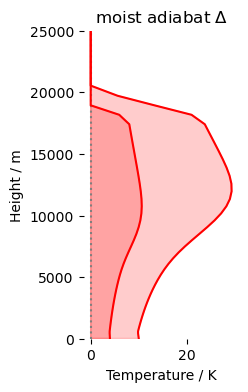

In [5]:
def plot_delta(ax, h, T_increase, T_s_0, T_min, p_surf, color='red'):
    p = hydrostatic_profile(h, p_surf=p_surf)
    k = joined_profile(p, T_s=T_s_0+T_increase, T_min=T_min) - joined_profile(p, T_s=T_s_0, T_min=T_min)
    ax.fill_betweenx(h, k, color=color, alpha=0.2)
    ax.plot(k,h, color=color)

cold = xr.open_dataset('../00_preliminary/luk100X_control_trades.nc')
h = np.flip(cold['zg'].values)
T_s_0 = cold['ta'].values[-1]
T_min = np.nanmin(cold['ta'].values)
p_surf = cold['pfull'].values[-1]

figsize = (2,4)
fig, ax = plt.subplots(figsize=figsize)
ax.axvline(0, ls=':', color='grey')

plot_delta(ax, h,  4, T_s_0, T_min, p_surf)
plot_delta(ax, h, 10, T_s_0, T_min, p_surf)

ax.set_title(f'moist adiabat $\Delta$')
ax.set_ylabel('Height / m')
ax.set_xlabel('Temperature / K')
ax.set_ylim(0,25000)
pu.remove_spines(ax)
plt.show()

## Multiple netcdf files

In [6]:
import os
BASE_PATH = '/work/mh1126/m300872/unchanged/'

grid = dict()
for dom in ['DOM01','DOM02']:
    grid[dom] = xr.open_dataset(BASE_PATH+'grids/'+f'EUREC4A_PR1250m_{dom}.nc')
    print(dom, '  ncell:', grid[dom].cell.shape)
    
init_path = BASE_PATH+'initc/20200109/'+'initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
init = xr.open_dataset(init_path)
print('initcon', 'ncell:', init.ncells.shape)

latbc_path = BASE_PATH+'latbc/lateral_boundary_DOM01.grid.nc'
latbc = xr.open_dataset(latbc_path)
print('latbc  ', 'ncell:', latbc.cell.shape)

DOM01   ncell: (4528560,)
DOM02   ncell: (11792076,)
initcon ncell: (4528560,)
latbc   ncell: (174068,)


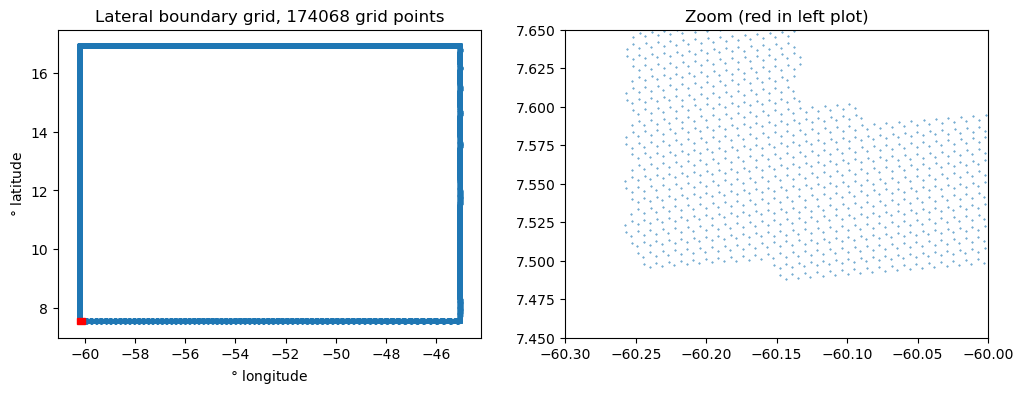

In [7]:
from matplotlib.patches import Rectangle

def grid_plot(grid, zoom):
    fig, axs = plt.subplots(1,2, figsize=(12,4))
    ax = axs[0]
    ax.scatter(np.rad2deg(grid.clon), np.rad2deg(grid.clat), marker='.', s=0.6, color='tab:blue')#, alpha=0.8)
    ax.add_patch(Rectangle((zoom[0][0], zoom[1][0]), np.abs(np.subtract(*zoom[0])), np.abs(np.subtract(*zoom[1])),color="red", lw=1))
    ax.set_title(f'Lateral boundary grid, {len(grid.cell.values)} grid points')
    ax.set_xlabel('$\degree$ longitude')
    ax.set_ylabel('$\degree$ latitude')
    ax = axs[1]
    ax.scatter(np.rad2deg(grid.clon), np.rad2deg(grid.clat), marker='.', s=0.6, color='tab:blue')#, alpha=0.8)
    ax.set_xlim(zoom[0])
    ax.set_ylim(zoom[1])
    ax.set_title('Zoom (red in left plot)')
    return fig, axs

fig, axs = grid_plot(
    grid=xr.open_dataset('/work/mh1126/m300872/unchanged/'+'latbc/lateral_boundary_DOM01.grid.nc'),
    zoom=((-60.3,-60), (7.45,7.65))
    )
plt.show()

The width of the nudge zone can be set when creating the boundary grid. If I understood correctly it also serves as a sponge layer to dampen the outward movement from the domain and impede reflections.

* [ICON Manual](https://www.dwd.de/EN/ourservices/nwv_icon_tutorial/pdf_volume/icon_tutorial2020_en.pdf) (Chapter 6.2)
* Heinze, R., Dipankar, A., Henken, C. C., Moseley, C., Sourdeval, O., Trömel, S., ... & Quaas, J. (2017). Large‐eddy simulations over Germany using ICON: A comprehensive evaluation. *Quarterly Journal of the Royal Meteorological Society*, 143(702), 69-100., DOI: [10.1002/qj.2947](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.2947)

In [8]:
# g = xr.open_dataset('/work/mh1126/m300872/unchanged/'+'latbc/lateral_boundary_DOM01.grid.nc')
# plt.hist(g.global_cell_index)
# plt.hist(grid['DOM01'].clon.isel(cell=g.global_cell_index-1))

### *(Sidetracked: Missing height levels)*

Apparently there are no full level heights available. Neither in the data, nor the grid files. 

In [9]:
import eurec4a;
vgrid = eurec4a.get_intake_catalog().simulations.grids['ecf22d17-dcee-1510-a807-11ae4a612be0'].to_dask()
for var in list(vgrid):
    try: print(var.ljust(15), vgrid[var].long_name)
    except: pass

fr_lake         fraction lake
fr_land         Fraction land
gz0             roughness length
topography_c    geometric height of the earths surface above sea level
z_ifc           geometric height at half level center


So we have to interpolate from half levels.

In [10]:
def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

Just because until now we have been working with constructed hydrostatic pressure profiles, let's see how much these differ from model output. Here we take the eurec4a ICON LES boundary conditions for the comparison (It is input, but it also is output from another model).

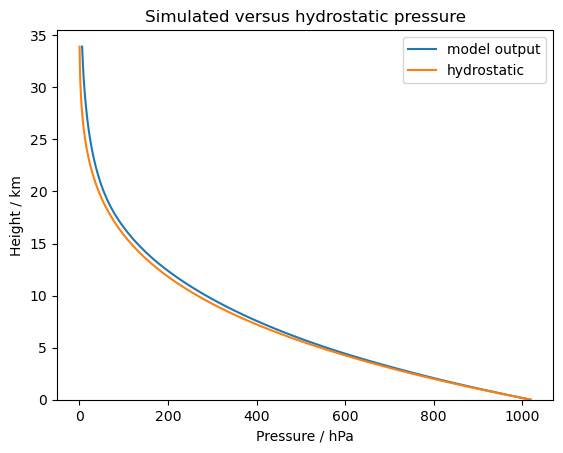

In [11]:
d = xr.open_dataset(BASE_PATH+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc')
z_ifc = np.flip(d['z_ifc'].isel(time=0,ncells=0).values)
z_full = interpolate_full_level(z_ifc)
p_surf = np.ravel(d['pres'].isel(time=0,ncells=0).values)[-1]
p = hydrostatic_profile(z_full, p_surf)

fig, ax = plt.subplots()
ax.plot(np.flip(np.ravel(d['pres'].isel(time=0,ncells=0).values))/100,z_full/1000, label='model output')
ax.plot(p/100,z_full/1000, label='hydrostatic')
ax.set_ylim(0,35.500)
ax.set_title('Simulated versus hydrostatic pressure')
ax.set_xlabel('Pressure / hPa')
ax.set_ylabel('Height / km')
ax.legend()
plt.show()

Jule told me she generally uses pressure to re-calculate the height. She only does this to 

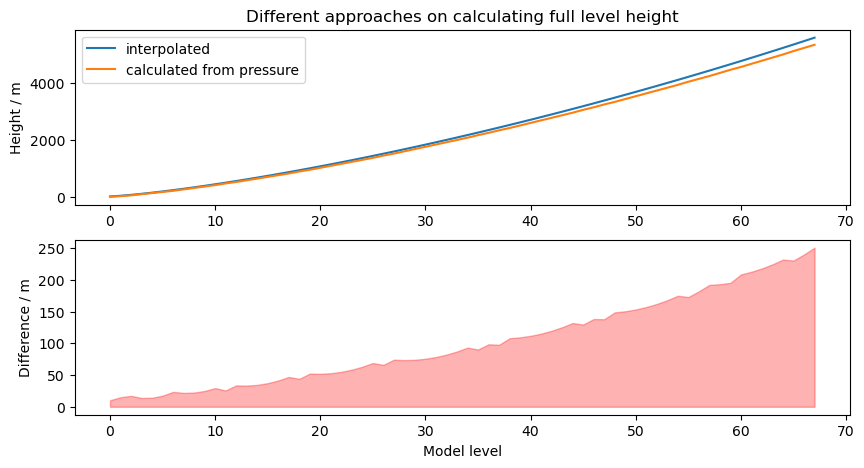

In [12]:
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import eurec4a
import matplotlib.pyplot as plt

def hydrostatic_profile(h, p_surf=100000):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_height_to_pressure.html
    # This assumes a standard atmosphere [NOAA1976].
    # mpcalc.add_height_to_pressure(pressure, height)
    p = np.zeros(len(h))
    p[0] = p_surf
    for i in range(1,len(p)):
        pressure = p[i-1] * units('Pa')
        height   = (h[i] - h[i-1]) * units('m')
        calc = mpcalc.add_height_to_pressure(pressure, height).to(units('Pa'))
        p[i] = calc.magnitude
        if p[i] == np.nan: p[i] = 0.0
    return p

def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

def nearest_value_index(array, value):
    # https://www.geeksforgeeks.org/find-the-nearest-value-and-the-index-of-numpy-array/
    difference_array = np.absolute(array-value)
    # index = difference_array.argmin()
    index = np.nanargmin(difference_array)
    return index

def pres2heigth(p, max_height=50000, meter_per_level=1):
    h = np.linspace(0,max_height, int(max_height/meter_per_level))
    p_ref = hydrostatic_profile(h, p[0])
    h = np.asarray([h[nearest_value_index(p_ref, value)] for value in p])
    return h

def print_table(a,b,col_width=10):
    if not len(a) == len(b): raise ValueError("Arrays have different size.")
    for i in range(len(a)):
        print(str(i).ljust(3), f'{a[i]:.2f}'.rjust(col_width), f'{b[i]:.2f}'.rjust(col_width))
        
data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control['3D_DOM01'].to_dask().isel(time=0).mean(dim='cell')
vgrid = eurec4a.get_intake_catalog().simulations.grids['ecf22d17-dcee-1510-a807-11ae4a612be0'].to_dask().mean(dim='cell')

model_p = np.flip(np.ravel(data['pres'].values))
h_from_p = pres2heigth(model_p, meter_per_level=10)
h_interpol = interpolate_full_level(np.flip(vgrid['z_ifc'].values))[0:len(h_from_p)]
x = range(len(h_from_p))

fig, axs = plt.subplots(2,1, figsize=(10,5))
ax = axs[0]
ax.plot(x,h_interpol, label='interpolated')
ax.plot(x,h_from_p,   label='calculated from pressure')
ax.legend()
ax.set_ylabel('Height / m')
ax.set_title('Different approaches on calculating full level height')
ax = axs[1]
ax.fill_between(x,h_interpol-h_from_p, color='red', alpha=0.3, label='difference')
# ax.legend(loc='upper left')
ax.set_xlabel('Model level')
ax.set_ylabel('Difference / m')
plt.show()

Interesting, but not useful. We will use the linear interpolation from half level heights as given in `interpolate_full_level()` to calculate our heights.

## Match the shape

The way we are trying to go here is:
 * Calculate the relative humidity `RH`
 * Create a numpy array with the dimensions of the temperature field
 * Write our deltas in it
 * Add it on top of existing boundary conditions
 * Readjust the specific humidity `qs` from `RH`.
 * (For the initial field: calculate `rho` and `theta_v`

Let's take some example dataset

In [13]:
latbc = xr.open_dataset(BASE_PATH+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc').mean(dim='time')
latbc_copy = latbc.copy() # for later reference

And add a new variable for relative humidity, based on its pressure, temperature and specific humidity. 

In [14]:
DEFAULT_VARNAMES = {'pressure':'pres',
                    'temperature':'temp',
                    'virtual potential temperature':'theta_v',
                    'density':'rho',
                    'specific humidity':'qv',
                    'relative humidity':'RH',
                    'half level height':'z_ifc'}

def add_varnames_to_default(custom_varnames):
    global DEFAULT_VARNAMES
    varnames = DEFAULT_VARNAMES
    if custom_varnames: # if any given, this will overwrite the default
        for key, value in custom_varnames.items(): varnames[key] = value
    return varnames
    
def add_relative_humidity(dataset, varnames=None):
    varnames = add_varnames_to_default(varnames)
    p  = dataset[varnames['pressure']].values    * units('pascal')
    t  = dataset[varnames['temperature']].values * units('kelvin')
    qv = dataset[varnames['specific humidity']].values   # ratio of water vapor mass to total moist air parcel mass

    rh = mpcalc.relative_humidity_from_specific_humidity(p, t, qv)
    # On adding variables to the dataset: https://stackoverflow.com/a/56590572
    dimnames = dataset[varnames['specific humidity']].dims
    dataset[varnames['relative humidity']] = (dimnames, rh.magnitude)
    return dataset

def restore_specific_humidity(dataset, varnames=None, drop_RH=True):
    varnames = add_varnames_to_default(varnames)
    p  = dataset[varnames['pressure']].values    * units('pascal')
    t  = dataset[varnames['temperature']].values * units('kelvin')
    rh = dataset[varnames['relative humidity']].values
    
    eps = mpcalc.mixing_ratio_from_relative_humidity(p, t, rh)
    qv = mpcalc.specific_humidity_from_mixing_ratio(eps)
    # On adding variables to the dataset: https://stackoverflow.com/a/56590572
    dimnames = dataset[varnames['relative humidity']].dims
    dataset[varnames['specific humidity']] = (dimnames, qv.magnitude)
    if drop_RH: dataset = dataset.drop_vars(varnames['relative humidity'])
    return dataset

latbc = add_relative_humidity(latbc)
latbc

<xarray.Dataset>
Dimensions:        (ncells: 174068, vertices: 3, height: 76, bnds: 2,
                    height_2: 76, height_3: 75)
Coordinates:
    clon           (ncells) float64 ...
    clat           (ncells) float64 ...
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 73.0 74.0 75.0 76.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 73.0 74.0 75.0 76.0
  * height_3       (height_3) float64 1.0 2.0 3.0 4.0 ... 72.0 73.0 74.0 75.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/16)
    clon_bnds      (ncells, vertices) float64 -0.7851 -0.7853 ... -1.051 -1.051
    clat_bnds      (ncells, vertices) float64 0.2736 0.2736 ... 0.1733 0.1734
    height_bnds    (height, bnds) float64 1.0 0.0 2.0 0.0 ... 75.0 0.0 76.0 0.0
    height_3_bnds  (height_3, bnds) float64 1.0 2.0 2.0 3.0 ... 75.0 75.0 76.0
    z_ifc          (height, ncells) float32 3.5e+04 3.5e+04 3.5e+04 ... 0.0 0.0
    w              (height_2, ncells) float32 0.0 0.0 ... -9.653e-12 3.762e-12
    ...             ...
    qs             (height_3, ncells) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u              (height_3, ncells) float32 -17.24 -17.23 ... -7.086 -7.019
    v              (height_3, ncells) float32 1.028 1.025 ... -3.537 -3.358
    temp           (height_3, ncells) float32 230.9 230.9 230.9 ... 300.1 300.1
    pres           (height_3, ncells) float32 623.1 623.1 ... 1.014e+05
    RH             (height_3, ncells) float32 0.0002061 0.0002062 ... 0.7413

We add a given temperature delta. Here we use the difference between the profiles for a 304 and 300 Kelvin surface temperature. Both profiles have a boundary layer at 950 hPa, following a dry adiabatic profile below and a moist adiabatic profile above this layer.

In [15]:
def construct_volume(column, shape):
    levels = [np.ones(shape) * value for value in np.flip(column)]
    return np.asarray(levels)

def joined_profile(p, p_threshold=95000, T_s=300, T_min=None):
    dry = metpy_dry_lapse_profile(p, T_s=T_s)
    hi = p <= p_threshold
    lo = p >  p_threshold
    moist = konrad_moist_adiabat(p[hi], T_s=dry[hi][0].magnitude)#, T_min=T_min)
    t = np.empty(len(p))
    t[lo] = dry[lo]
    t[hi] = moist
    return t

delta = joined_profile(p, T_s=304) - joined_profile(p, T_s=300)

And we add this delta on top of our existing values.

In [16]:
def add_to_temperature(dataset, delta, varnames=None):
    varnames = add_varnames_to_default(varnames)
    z = dataset[varnames['half level height']].isel(ncells=0).values
    h = interpolate_full_level(np.flip(z))
    p = np.flip(dataset[varnames['pressure']].mean(dim='ncells').values)

    temp_delta = construct_volume(delta, dataset.ncells.shape)
    dataset[varnames['temperature']].values = dataset[varnames['temperature']].values + temp_delta
    return dataset


latbc = add_to_temperature(latbc, delta)

And restore our previous relative humidity.

In [17]:
latbc = restore_specific_humidity(latbc)

While the ICON does not require the prognostic variables 'theta_v' and 'rho' at the boundaries, it does so for the initial conditions. Since we have the lateral boundary conditions loaded here, we will just use this for testing.

In [18]:
def add_prognostic_variables(dataset, varnames=None):
    varnames = add_varnames_to_default(varnames)
    p  = dataset[varnames['pressure']].values    * units('pascal')
    t  = dataset[varnames['temperature']].values * units('kelvin')
    qv = dataset[varnames['specific humidity']].values   # ratio of water vapor mass to total moist air parcel mass
    
    eps   = mpcalc.mixing_ratio_from_specific_humidity(qv)
    theta = mpcalc.virtual_potential_temperature(p,t,eps)
    rho   = mpcalc.density(p, t, eps)
    
    dimnames = dataset[varnames['temperature']].dims
    dataset[varnames['virtual potential temperature']] = (dimnames, theta.magnitude)
    dataset[varnames['density']] = (dimnames, rho.magnitude)
    return dataset

latbc = add_prognostic_variables(latbc)

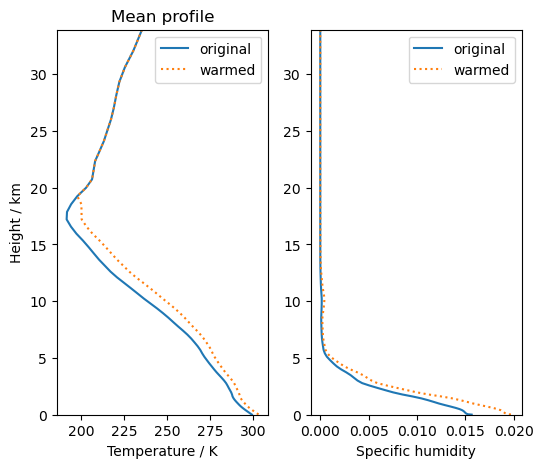

In [19]:
h = interpolate_full_level(np.flip(latbc['z_ifc'].isel(ncells=0).values)) / 1000
    
fig, axs = plt.subplots(1,2,figsize=(6,5))
ax = axs[0]
ax.set_title('Mean profile')
ax.set_ylabel('Height / km')
ax.set_xlabel('Temperature / K')
ax.plot(latbc_copy['temp'].mean(dim='ncells'), np.flip(h), label='original')
ax.plot(latbc['temp'].mean(dim='ncells') , np.flip(h), ls=':', label='warmed',)
ax = axs[1]
ax.set_xlabel('Specific humidity')
ax.plot(latbc_copy['qv'].mean(dim='ncells'), np.flip(h), label='original')
ax.plot(latbc['qv'].mean(dim='ncells') , np.flip(h), ls=':', label='warmed',)
for ax in axs: 
    ax.set_ylim(0,np.nanmax(h))
    ax.legend()
plt.show()

Saving the file works just fine.

In [20]:
import os

def gb(byte):
    return byte / 1e9

path = 'delete_me.nc'
latbc.to_netcdf(path)
print(f"{path.ljust(30)} : {gb(os.path.getsize(path)):.3f} GB")
os.remove(path) 

delete_me.nc                   : 0.900 GB


We now want a function that does all of the above. We want it to receive an input file path, an output path, and a type of change to apply. This could be generalized to capture the `latbc`, the `sst_sic` and the `initcon` files all at once. But this might not be worth the effort, since the non-`latbc` files are only a few.

In [21]:
from function_timer import function_timer
# @function_timer
def warm_atmospheric_profile(kwargs):
    ifile = kwargs['ifile']
    ofile = kwargs['ofile']
    warming_profile = kwargs['profile']
    d = xr.open_dataset(ifile)
    d = add_relative_humidity(d)
    d = add_to_temperature(d, warming_profile)
    d = restore_specific_humidity(d, drop_RH=True)
    d.to_netcdf(ofile)

ifile = BASE_PATH+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc'
ofile = 'delete_me.nc'
delta = joined_profile(p, T_s=304) - joined_profile(p, T_s=300)
warm_atmospheric_profile({'ifile':ifile, 'ofile':ofile, 'profile':delta})

print(f"{ofile.ljust(30)} : {gb(os.path.getsize(ofile)):.3f} GB")
x = xr.open_dataset(ofile)
os.remove(ofile) 
x

delete_me.nc                   : 0.639 GB


<xarray.Dataset>
Dimensions:        (time: 1, ncells: 174068, vertices: 3, height: 76, bnds: 2,
                    height_2: 76, height_3: 75)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-08T01:00:00
    clon           (ncells) float64 ...
    clat           (ncells) float64 ...
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 73.0 74.0 75.0 76.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 73.0 74.0 75.0 76.0
  * height_3       (height_3) float64 1.0 2.0 3.0 4.0 ... 72.0 73.0 74.0 75.0
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/15)
    clon_bnds      (ncells, vertices) float64 ...
    clat_bnds      (ncells, vertices) float64 ...
    height_bnds    (height, bnds) float64 ...
    height_3_bnds  (height_3, bnds) float64 ...
    z_ifc          (time, height, ncells) float32 ...
    w              (time, height_2, ncells) float32 ...
    ...             ...
    qr             (time, height_3, ncells) float32 ...
    qs             (time, height_3, ncells) float32 ...
    u              (time, height_3, ncells) float32 ...
    v              (time, height_3, ncells) float32 ...
    temp           (time, height_3, ncells) float32 ...
    pres           (time, height_3, ncells) float32 ...
Attributes:
    CDI:             Climate Data Interface version 1.9.7 (http://mpimet.mpg....
    Conventions:     CF-1.6
    uuidOfHGrid:     f70a2faa-0fa0-b934-f7fc-f3b9e8c72f20
    uuidOfVGrid:     dea5fc13-f89b-ff83-beb9-afbd8add2e40
    source:          git@git.mpimet.mpg.de:dwd_icon_tools.git, branch master,...
    institution:     Max Planck Institute for Meteorology
    DWD ICON Tools:  git@git.mpimet.mpg.de:dwd_icon_tools.git :: master, rev....
    parent_file:     /work/bb1156/ICON-1.25km/DATA/2020010700/dei4_EUREC4a1_2...
    history:         Tue May  4 16:53:54 2021: ncatted -O -a parent_file,glob...
    NCO:             netCDF Operators version 4.9.3 (Homepage = http://nco.sf...

Next we want input and output files. Let's copypaste some old code...

In [22]:
import os

def get_hash(string):
    # https://www.pythoncentral.io/hashing-strings-with-python/
    hash_object = hashlib.sha1(string.encode())
    return hash_object.hexdigest()

def basename(path, extension=True):
    if extension: 
        return os.path.basename(path)
    else: # removes extension
        return os.path.splitext(os.path.basename(path))[0]
    
def dirname(path):
    return os.path.dirname(path)

def extension(path):
    return os.path.splitext(path)[1]

def is_netcdf(f):
    return extension(f) == '.nc'

def get_filelist(lost_path, conserved_path):
    '''
    crawls the directory `lost_path`+`conserved_path` and 
    returns a list of files in all subdirectories. The returned 
    paths are relative paths to `lost_path`.
    '''
    file_list = []
    for root, directories,files in os.walk(os.path.join(lost_path, conserved_path)):
        for name in files: 
            if is_netcdf(name):
                path = os.path.join(os.path.relpath(root, start=lost_path), name)
                file_list.append(path)
    return file_list

In [23]:
IN_DIRECTORY  = '/work/mh1126/m300872/unchanged/'
OUT_DIRECTORY = '/work/mh1126/m300872/moist_adiabatic/'
latbc_files = get_filelist(IN_DIRECTORY, 'latbc/')[1::]
initc_files = get_filelist(IN_DIRECTORY, 'initc')
sstsi_files = [f for f in get_filelist(IN_DIRECTORY, 'sst_sic') if 'DOM01' in f or 'DOM02' in f]
print(len(latbc_files),len(initc_files), len(sstsi_files) )

1025 1 2


In [24]:
def create_directory_structure(file_list):
    for f in file_list:
        dirpath = os.path.join(OUT_DIRECTORY,dirname(f))
        os.makedirs(dirpath, exist_ok=True)

create_directory_structure(latbc_files + initc_files + sstsi_files)
delta = joined_profile(p, T_s=304) - joined_profile(p, T_s=300)

args_list = list()
for f in latbc_files[0:3]:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append({'ifile':ifile, 'ofile':ofile, 'profile':delta})

for args in args_list:
    warm_atmospheric_profile(args)

Its time to pack this into a script and make use of slurm. This is the set of functions we want to use:

In [25]:
# functions for boundary script launch
function_cell_identifier = '20fc0f1218ac5b943e1732792bbbdcfb11d7a026' # == get_hash('function_cell_identifier')
# identifier is used to save cell content into file later
import os
import hashlib
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
# The import from konrad was failing on the first, but succeding on second attempt. With this error message:
# File ~/.local/lib/python3.10/site-packages/climt/_components/_berger_solar_insolation.pyx:1, in init climt._components._berger_solar_insolation()
# ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject
# This is the work around
try:
    from konrad.lapserate import get_moist_adiabat as konrad_moist_adiabat
except:
    from konrad.lapserate import get_moist_adiabat as konrad_moist_adiabat
# get_moist_adiabat(p, p_s=None, T_s=300.0, T_min=155.0)
# https://konrad.readthedocs.io/_modules/konrad/lapserate.html#get_moist_adiabat

def get_hash(string):
    # https://www.pythoncentral.io/hashing-strings-with-python/
    hash_object = hashlib.sha1(string.encode())
    return hash_object.hexdigest()

def basename(path, extension=True):
    if extension: 
        return os.path.basename(path)
    else: # removes extension
        return os.path.splitext(os.path.basename(path))[0]
    
def dirname(path):
    return os.path.dirname(path)

def extension(path):
    return os.path.splitext(path)[1]

def is_netcdf(f):
    return extension(f) == '.nc'

def get_filelist(lost_path, conserved_path):
    file_list = []
    for root, directories,files in os.walk(os.path.join(lost_path, conserved_path)):
        for name in files: 
            if is_netcdf(name):
                path = os.path.join(os.path.relpath(root, start=lost_path), name)
                file_list.append(path)
    file_list.sort()
    return file_list

def create_directory_structure(file_list, out_directory):
    for f in file_list:
        dirpath = os.path.join(out_directory,dirname(f))
        os.makedirs(dirpath, exist_ok=True)
        
def sublist(inlist, n_lists, index):
    return list(np.array_split(inlist, n_lists)[index])

def hydrostatic_profile(h, p_surf=100000):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.add_height_to_pressure.html
    # This assumes a standard atmosphere [NOAA1976].
    # mpcalc.add_height_to_pressure(pressure, height)
    p = np.zeros(len(h))
    p[0] = p_surf
    for i in range(1,len(p)):
        pressure = p[i-1] * units('Pa')
        height   = (h[i] - h[i-1]) * units('m')
        calc = mpcalc.add_height_to_pressure(pressure, height).to(units('Pa'))
        p[i] = calc.magnitude
        if p[i] == np.nan: p[i] = 0.0
    return p

# these two still have the problem, that they crash if the temperature gets too cold.
def metpy_dry_lapse_profile(p, T_s=300, T_min=None):
    # https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dry_lapse.html#metpy.calc.dry_lapse
    # metpy.calc.dry_lapse(pressure, temperature, reference_pressure=None, vertical_dim=0)
    t = mpcalc.dry_lapse(p * units('Pa'),  temperature=T_s * units('kelvin'))
    if T_min: t = np.where(t.magnitude > T_min, t, T_min * units('kelvin'))
    return t

def joined_profile(p, p_threshold=95000, T_s=300, T_min=None):
    dry = metpy_dry_lapse_profile(p, T_s=T_s)
    hi = p <= p_threshold
    lo = p >  p_threshold
    moist = konrad_moist_adiabat(p[hi], T_s=dry[hi][0].magnitude)#, T_min=T_min)
    t = np.empty(len(p))
    t[lo] = dry[lo]
    t[hi] = moist
    return t

def construct_volume(column, shape):
    levels = [np.ones(shape) * value for value in np.flip(column)]
    return np.asarray(levels)

def interpolate_full_level(half_level):
    return np.asarray([(half_level[i]+half_level[i-1])/2 for i in range(1,len(half_level))])

DEFAULT_VARNAMES = {'pressure':'pres',
                    'temperature':'temp',
                    'virtual potential temperature':'theta_v',
                    'density':'rho',
                    'specific humidity':'qv',
                    'relative humidity':'RH',
                    'half level height':'z_ifc'}

def add_varnames_to_default(custom_varnames):
    global DEFAULT_VARNAMES
    varnames = DEFAULT_VARNAMES
    if custom_varnames: # if any given, this will overwrite the default
        for key, value in custom_varnames.items(): varnames[key] = value
    return varnames
    
def add_relative_humidity(dataset, varnames=None):
    varnames = add_varnames_to_default(varnames)
    p  = dataset[varnames['pressure']].values    * units('pascal')
    t  = dataset[varnames['temperature']].values * units('kelvin')
    qv = dataset[varnames['specific humidity']].values   # ratio of water vapor mass to total moist air parcel mass

    rh = mpcalc.relative_humidity_from_specific_humidity(p, t, qv)
    # On adding variables to the dataset: https://stackoverflow.com/a/56590572
    dimnames = dataset[varnames['specific humidity']].dims
    dataset[varnames['relative humidity']] = (dimnames, rh.magnitude)
    return dataset

def restore_specific_humidity(dataset, varnames=None, drop_RH=True):
    varnames = add_varnames_to_default(varnames)
    p  = dataset[varnames['pressure']].values    * units('pascal')
    t  = dataset[varnames['temperature']].values * units('kelvin')
    rh = dataset[varnames['relative humidity']].values
    
    eps = mpcalc.mixing_ratio_from_relative_humidity(p, t, rh)
    qv = mpcalc.specific_humidity_from_mixing_ratio(eps)
    # On adding variables to the dataset: https://stackoverflow.com/a/56590572
    dimnames = dataset[varnames['relative humidity']].dims
    dataset[varnames['specific humidity']] = (dimnames, qv.magnitude)
    if drop_RH: dataset = dataset.drop_vars(varnames['relative humidity'])
    return dataset

def add_to_temperature(dataset, delta, varnames=None):
    varnames = add_varnames_to_default(varnames)
    z = dataset[varnames['half level height']].isel(ncells=0).values
    h = interpolate_full_level(np.flip(z))
    p = np.flip(dataset[varnames['pressure']].mean(dim='ncells').values)

    temp_delta = construct_volume(delta, dataset.ncells.shape)
    dataset[varnames['temperature']].values = dataset[varnames['temperature']].values + temp_delta
    return dataset

def add_prognostic_variables(dataset, varnames=None):
    varnames = add_varnames_to_default(varnames)
    p  = dataset[varnames['pressure']].values    * units('pascal')
    t  = dataset[varnames['temperature']].values * units('kelvin')
    qv = dataset[varnames['specific humidity']].values   # ratio of water vapor mass to total moist air parcel mass
    
    eps   = mpcalc.mixing_ratio_from_specific_humidity(qv)
    theta = mpcalc.virtual_potential_temperature(p,t,eps)
    rho   = mpcalc.density(p, t, eps)
    
    dimnames = dataset[varnames['temperature']].dims
    dataset[varnames['virtual potential temperature']] = (dimnames, theta.magnitude)
    dataset[varnames['density']] = (dimnames, rho.magnitude)
    return dataset

def warm_atmospheric_profile(ifile,ofile,warming_profile,varnames=None):
    d = xr.open_dataset(ifile)
    d = add_relative_humidity(d, varnames=varnames)
    d = add_to_temperature(d, warming_profile, varnames=varnames)
    d = restore_specific_humidity(d, drop_RH=True, varnames=varnames)
    d.to_netcdf(ofile)

def delta_adiabatic_profile(t_high,t_low,file_for_z):
    d = xr.open_dataset(file_for_z)
    z_ifc = np.flip(d['z_ifc'].isel(time=0,ncells=0).values)
    z_full = interpolate_full_level(z_ifc)
    p_surf = 100000 # np.ravel(d['pres'].isel(time=0,ncells=0).values)[-1]
    p = hydrostatic_profile(z_full, p_surf)
    delta = joined_profile(p, T_s=t_high) - joined_profile(p, T_s=t_low)
    return delta

Here they are contained in a string. Also a slurm header and a few functions to generate and launch scripts.

In [26]:
# a sound alarm to notify me, a cell has finished. i get distracted.
# https://gist.github.com/tamsanh/a658c1b29b8cba7d782a8b3aed685a24
from IPython.lib.display import Audio
import numpy as np

def beep(): 
    t = np.linspace(0, 0.3, int(4410/7))
    audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
    return Audio(audio_data, rate=4410, autoplay=True)


import pandas as pd
import subprocess as sup
import os

# get the functions from the cell above and save them to a file
functions = [cell for cell in _ih if function_cell_identifier in cell][0]
with open("functions_boundaries.py", "w") as f:
    f.writelines(functions)

def seconds2clockstring(s):
    hours, remainder = divmod(s, 3600)
    minutes, seconds = divmod(remainder, 60)
    return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))

def minutes2clockstring(m):
    s = pd.Timedelta(m, 'm').total_seconds()
    return seconds2clockstring(s)
    
def slurm_header(minutes):
    return f'''#!/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/bin/python
#SBATCH --partition=compute
#SBATCH --account=mh0926
#SBATCH --nodes=1
#SBATCH --time={minutes2clockstring(minutes)}
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j_%x.log
'''

def latbc_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic/',
                      temperatures=(304,300)):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
latbc_files = [f for f in get_filelist(IN_DIRECTORY, 'latbc/') if not 'grid' in f]
create_directory_structure(latbc_files, OUT_DIRECTORY)
if division: latbc_files = sublist(latbc_files, division[0], division[1])

warming_profile = delta_adiabatic_profile({temperatures[0]}, {temperatures[1]}, IN_DIRECTORY+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc')
                                           
args_list = list()
for f in latbc_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,warming_profile))

for args in args_list:
    warm_atmospheric_profile(*args)
'''

def initc_script_body(in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic/',
                      temperatures=(304,300)):
    return f'''
IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
initc_files = get_filelist(IN_DIRECTORY, 'initc')
create_directory_structure(initc_files, OUT_DIRECTORY)
print(initc_files)

warming_profile = delta_adiabatic_profile({temperatures[0]}, {temperatures[1]}, IN_DIRECTORY+'latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc')

ifile = os.path.join(IN_DIRECTORY,initc_files[0])
ofile = os.path.join(OUT_DIRECTORY,initc_files[0])
varnames = dict()
varnames['pressure']    = 'p'
varnames['temperature'] = 't'
print(varnames)
d = xr.open_dataset(ifile)
d = add_relative_humidity(d, varnames=varnames)
d = add_to_temperature(d, warming_profile, varnames=varnames)
d = restore_specific_humidity(d, drop_RH=True, varnames=varnames)
d = add_prognostic_variables(d, varnames=varnames)
d.to_netcdf(ofile)
'''

def sstsic_script_body(division=False, 
                      in_directory='/work/mh1126/m300872/unchanged/',
                      out_directory='/work/mh1126/m300872/moist_adiabatic/',
                      temperatures=(304,300)):
    return f'''
import netCDF4 as nc
import xarray as xr
import subprocess as sup
# from functions_boundaries import *

IN_DIRECTORY  = '{in_directory}'
OUT_DIRECTORY = '{out_directory}'
division = {division}
temperatures = {temperatures}

print(division)
sstsic_files = [f for f in get_filelist(IN_DIRECTORY, 'sst_sic') if 'DOM01' in f or 'DOM02' in f or 'DOM03' in f]
if division: sstsic_files = sublist(sstsic_files, division[0], division[1])
create_directory_structure(sstsic_files, OUT_DIRECTORY)
    
# pack arguments
delta = temperatures[1] - temperatures[0]
args_list = list()
for f in sstsic_files:
    ifile = os.path.join(IN_DIRECTORY,f)
    ofile = os.path.join(OUT_DIRECTORY,f)
    args_list.append((ifile,ofile,delta))

for args in args_list:
    # copy original file, then overwrite SST timestepwise (file to big to write at once)
    (ifile, ofile, delta) = args
    sup.call(['cp', ifile, ofile])
    time_shape = xr.open_dataset(ifile).time.values.shape
    with nc.Dataset(args[1], mode='a') as fp:
        for i in range(time_shape[0]):
            chunk = xr.open_dataset(ifile)['SST'].isel(time=i).values + delta
            fp['SST'][i] = chunk
'''

def try_remove(path):
    try:os.remove(path)
    except: pass

def launch_script(body, name='/scratch/m/m300872/generated_script.py'):
    try_remove(name)
    with open(name, 'w') as file:
        file.write(body)
    sup.call(['sbatch', name])
    try_remove(name)
    
def launch_latbc_scripts(n_scripts=100):
    for script_id in range(n_scripts):
        script = slurm_header(5) + functions + latbc_script_body(division=(n_scripts, script_id))
        launch_script(script)

def launch_initc_script():
    script = slurm_header(10) + functions + initc_script_body()
    launch_script(script)

def launch_sstsic_script(n_scripts=3):
    for script_id in range(n_scripts):
        script = slurm_header(15) + functions + sstsic_script_body(division=(n_scripts, script_id))
        launch_script(script)

The following will actually launch the scripts (commented out, because its computationally intensive and I don't want to run it accidentally).

In [27]:
# launch_latbc_scripts(n_scripts=40)
# launch_initc_script()
launch_sstsic_script()

Submitted batch job 2852233
Submitted batch job 2852234
Submitted batch job 2852235


Did we actually produce files?

In [29]:
OUT_DIRECTORY = '/work/mh1126/m300872/moist_adiabatic/'
for d in ['initc/', 'latbc/', 'sst_sic/']:
    written_files = get_filelist(OUT_DIRECTORY, d)
    print(d.ljust(8), ':', len(written_files))

initc/   : 1
latbc/   : 1025
sst_sic/ : 3


Looks like we got our files :+1:

Clean up log files:

In [4]:
import os
logfiles = [f for f in os.listdir('./') if f[-4::] == '.log' ]
for f in logfiles: os.remove(f)